## Model example
---

Example showing how to create a GPD/EQTransformer model, load pretrained weights from the SeisBench repository and annotate a waveform.

**Current version of the model API is incomplete and subject to change.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import obspy
import matplotlib.pyplot as plt

from seisbench.models import GPD, WaveformModel, EQTransformer, PhaseNet, CRED

### Build a GPD model from using pretrained weights from the SeisBench remote repository

In [3]:
model = GPD.from_pretrained("original")
# model = CRED.from_pretrained("original")
model.cuda();

In [4]:
print(model.weights_docstring)

Original GPD model from Ross et al. (2018). Originally published under MIT License. Original available at https://github.com/interseismic/generalized-phase-detection/blob/ea81ef17d204797de6a99d277fd2b9407fc77df7/model_pol_best.hdf5 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@gfz-potsdam.de)


### Annotate obspy example waveform and visualize predictions

In [5]:
stream = obspy.read()

In [6]:
annotations = model.annotate(stream)
picks = model.classify(stream)

In [7]:
picks

[('BW.RJOB.', 2009-08-24T00:20:06.900000Z, 'P'),
 ('BW.RJOB.', 2009-08-24T00:20:08.200000Z, 'S')]

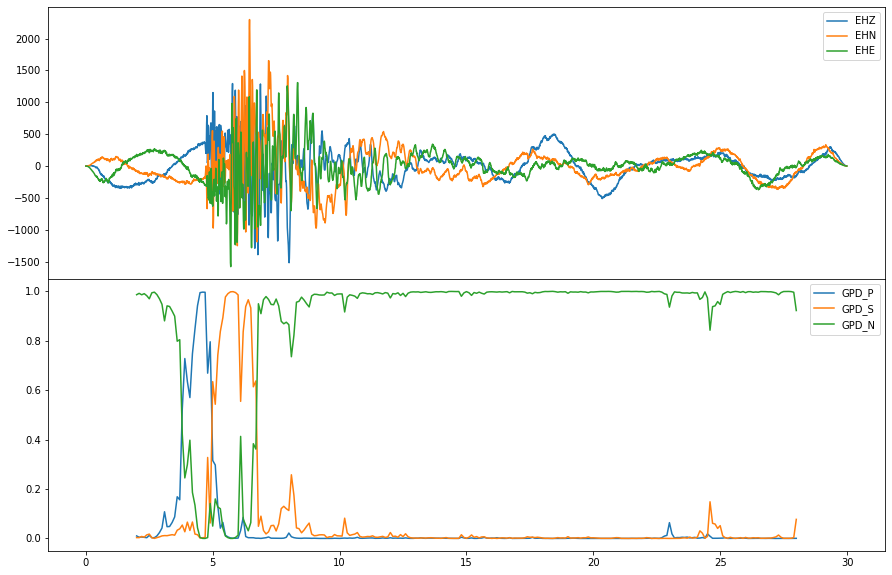

In [8]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

t_base = stream[0].stats.starttime
line_map = {"P": "-", "S": "--"}
# for trace_id, t0, phase in picks:
#     axs[0].axvline(t0 - t_base, color="k", ls=line_map[phase])
    
axs[0].legend()
axs[1].legend()

### Download waveforms through FDSN and annotate with EQTransformer

In [9]:
model = EQTransformer.from_pretrained("original")
model.cuda();

In [10]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [11]:
client = Client("GFZ")

# t = UTCDateTime("2014/04/02")
t = UTCDateTime("2010/04/02")

stream = client.get_waveforms(network="CX", station="PB01", location="*", channel="HH?", starttime=t-500, endtime=t+600)
stream += client.get_waveforms(network="CX", station="PB02", location="*", channel="HH?", starttime=t-500, endtime=t+600)

In [12]:
annotations = model.annotate(stream)
picks, detections = model.classify(stream)

In [13]:
stream.filter("highpass", freq=1)

6 Trace(s) in Stream:
CX.PB01..HHZ | 2010-04-01T23:51:39.998393Z - 2010-04-02T00:09:59.998393Z | 100.0 Hz, 110001 samples
CX.PB01..HHE | 2010-04-01T23:51:39.998393Z - 2010-04-02T00:09:59.998393Z | 100.0 Hz, 110001 samples
CX.PB01..HHN | 2010-04-01T23:51:39.998393Z - 2010-04-02T00:09:59.998393Z | 100.0 Hz, 110001 samples
CX.PB02..HHZ | 2010-04-01T23:51:39.998393Z - 2010-04-02T00:09:59.998393Z | 100.0 Hz, 110001 samples
CX.PB02..HHE | 2010-04-01T23:51:39.998393Z - 2010-04-02T00:09:59.998393Z | 100.0 Hz, 110001 samples
CX.PB02..HHN | 2010-04-01T23:51:39.998393Z - 2010-04-02T00:09:59.998393Z | 100.0 Hz, 110001 samples

(-150.0, 150.0)

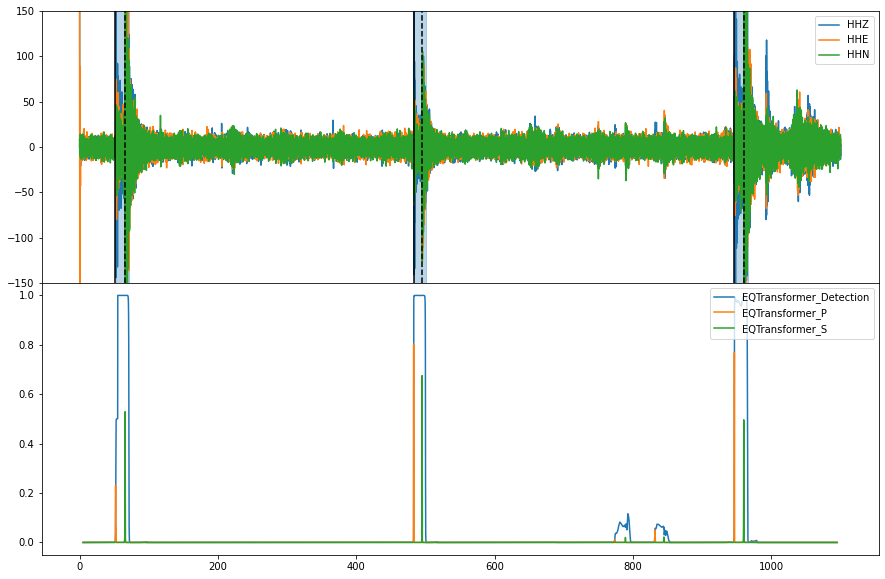

In [14]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

t_base = stream[0].stats.starttime
for trace_id, t0, t1 in detections:
    if trace_id == "CX.PB01.":
        axs[0].fill_between([t0 - t_base, t1 - t_base], 1e10, -1e10, color='C0', alpha=0.3)
    
line_map = {"P": "-", "S": "--"}
for trace_id, t0, phase in picks:
    if trace_id == "CX.PB01.":
        axs[0].axvline(t0 - t_base, color="k", ls=line_map[phase])
    
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
# axs[0].set_ylim(-1.5e6, 1.5e6)
axs[0].set_ylim(-1.5e2, 1.5e2)

In [ ]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3, 6):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

t_base = stream[3].stats.starttime
for trace_id, t0, t1 in detections:
    if trace_id == "CX.PB02.":
        axs[0].fill_between([t0 - t_base, t1 - t_base], 1e10, -1e10, color='C0', alpha=0.3)
    
line_map = {"P": "-", "S": "--"}
for trace_id, t0, phase in picks:
    if trace_id == "CX.PB02.":
        axs[0].axvline(t0 - t_base, color="k", ls=line_map[phase])
    
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
# axs[0].set_ylim(-3e6, 3e6)
axs[0].set_ylim(-3e2, 3e2)

(-300.0, 300.0)

# 